In [1]:
import tensorflow as tf

print(tf.__version__)

TRAIN_DATA_URL = "file:////Users/shaoyongzhen/code/recommend/SparrowRecSys/src/main/resources/webroot/sampledata/modelSamples.csv"
samples_file_path = tf.keras.utils.get_file("modelSamples.csv", TRAIN_DATA_URL)

2024-05-11 12:07:14.470065: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.16.1


In [2]:
# 载入测试数据
def get_dataset(file_path):
    dataset = tf.data.experimental.make_csv_dataset(
        file_path,
        batch_size=12,
        label_name='label',
        na_value="?",
        num_epochs=1,
        ignore_errors=True)
    return dataset



# sample dataset size 110830/12(batch_size) = 9235
raw_samples_data = get_dataset(samples_file_path)
print(raw_samples_data)


test_dataset = raw_samples_data.take(1000)
train_dataset = raw_samples_data.skip(1000)


Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.
<_PrefetchDataset element_spec=(OrderedDict([('movieId', TensorSpec(shape=(None,), dtype=tf.int32, name=None)), ('userId', TensorSpec(shape=(None,), dtype=tf.int32, name=None)), ('rating', TensorSpec(shape=(None,), dtype=tf.float32, name=None)), ('timestamp', TensorSpec(shape=(None,), dtype=tf.int32, name=None)), ('releaseYear', TensorSpec(shape=(None,), dtype=tf.int32, name=None)), ('movieGenre1', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('movieGenre2', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('movieGenre3', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('movieRatingCount', TensorSpec(shape=(None,), dtype=tf.int32, name=None)), ('movieAvgRating', TensorSpec(shape=(None,), dtype=tf.float32, name=None)), ('movieRatingStddev', TensorSpec(shape=(None,), dtype=tf.float32, name=None)), ('userRatedMovie1', TensorSpec(shape=(None,), dtype=tf.int32, name=None)), ('userRatedMovie2', 

In [3]:
# 3、载入类别型特征
# 类别型特征主要有这三类，分别是 genre、userId 和 movieId
genre_vocab = ['Film-Noir', 'Action', 'Adventure', 'Horror', 'Romance', 'War', 'Comedy', 'Western', 'Documentary',
               'Sci-Fi', 'Drama', 'Thriller',
               'Crime', 'Fantasy', 'Animation', 'IMAX', 'Mystery', 'Children', 'Musical']


GENRE_FEATURES = {
    'userGenre1': genre_vocab,
    'userGenre2': genre_vocab,
    'userGenre3': genre_vocab,
    'userGenre4': genre_vocab,
    'userGenre5': genre_vocab,

    'movieGenre1': genre_vocab,
    'movieGenre2': genre_vocab,
    'movieGenre3': genre_vocab
}


categorical_columns = []

for feature, vocab in GENRE_FEATURES.items():
    # 载入 genre 类特征时，采用 tf.feature_column.categorical_column_with_vocabulary_list 方法把字符串型的特征转换成了 One-hot 特征。
    # 在这个转换过程中需要用到一个词表，可以看到在开头就定义好了包含所有 genre 类别的词表 genre_vocab
    cat_col = tf.feature_column.categorical_column_with_vocabulary_list(
        key=feature, vocabulary_list=vocab)
    # 将分类列转换为嵌入列，这些浅入列可以被模型来学习特征的低维表示
    emb_col = tf.feature_column.embedding_column(cat_col, 10)
    categorical_columns.append(emb_col)


'''
EmbeddingColumn(
    categorical_column=VocabularyListCategoricalColumn(
        key='userGenre1', 
        vocabulary_list=('Film-Noir', 'Action', 'Adventure', 'Horror', 'Romance', 'War', 'Comedy', 'Western', 'Documentary', 'Sci-Fi', 'Drama', 'Thriller', 'Crime', 'Fantasy', 'Animation', 'IMAX', 'Mystery', 'Children', 'Musical'), 
        dtype=tf.string, 
        default_value=-1, 
        num_oov_buckets=0),
    dimension=10, 
    combiner='mean', 
    initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x1394b0a50>, 
    ckpt_to_load_from=None, 
    tensor_name_in_ckpt=None, 
    max_norm=None, 
    trainable=True, 
    use_safe_embedding_lookup=True)
'''
print(categorical_columns[0])

# 使用电影ID创建分类列，这些ID是唯一的，不需要词汇表
# tf.feature_column.categorical_column_with_identity 方法把 ID 转换成 One-hot 特征，
# 这个方法不用词表，它会直接把 ID 值对应的那个维度置为 1。比如，我们输入这个方法的 movieId 是 340，总的 movie 数量是 1001，使用这个方法，就会把这个 1001 维的 One-hot movieId 向量的第 340 维置为 1，剩余的维度都为 0
movie_col = tf.feature_column.categorical_column_with_identity(key='movieId', num_buckets=1001)
# 为了把稀疏的 One-hot 特征转换成稠密的 Embedding 向量，还需要在 One-hot 特征外包裹一层 Embedding 层，
# tf.feature_column.embedding_column(movie_col, 10) 方法完成了这样的操作，它在把 movie one-hot 向量映射到了一个 10 维的 Embedding 层上。
movie_emb_col = tf.feature_column.embedding_column(movie_col, 10)
categorical_columns.append(movie_emb_col)

# 同 movie_col
user_col = tf.feature_column.categorical_column_with_identity(key='userId', num_buckets=30001)
user_emb_col = tf.feature_column.embedding_column(user_col, 10)
categorical_columns.append(user_emb_col)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='userGenre1', vocabulary_list=('Film-Noir', 'Action', 'Adventure', 'Horror', 'Romance', 'War', 'Comedy', 'Western', 'Documentary', 'Sci-Fi', 'Drama', 'Thriller', 'Crime', 'Fantasy', 'Animation', 'IMAX', 'Mystery', 'Children', 'Musical'), dtype=tf.string, default_value=-1, num_oov_buckets=0), dimension=10, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0

In [4]:
# 4、数值型特征的处理
# 直接把特征值输入到 MLP 内，然后把特征逐个声明为 tf.feature_column.numeric_column 就可以了，不需要经过其他的特殊处理。
numerical_columns = [tf.feature_column.numeric_column('releaseYear'),
                   tf.feature_column.numeric_column('movieRatingCount'),
                     tf.feature_column.numeric_column('movieAvgRating'),
                     tf.feature_column.numeric_column('movieRatingStddev'),
                     tf.feature_column.numeric_column('userRatingCount'),
                     tf.feature_column.numeric_column('userAvgRating'),
                     tf.feature_column.numeric_column('userRatingStddev')]

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


In [7]:
# 5、定义模型结构
# 利用 DenseFeatures 把类别型 Embedding 特征和数值型特征连接在一起形成稠密特征向量，
# 然后依次经过两层 128 维的全连接层，最后通过 sigmoid 输出神经元产生最终预估值。
# from tensorflow.python.keras.layers.preprocessing import dense_features as DenseFeatures



# preprocessing_layer = DenseFeatures.DenseFeatures(
#     numerical_columns + categorical_columns)

feature_columns = numerical_columns + categorical_columns
preprocessing_layer = tf.keras.layers.DenseFeatures(feature_columns)

model = tf.keras.Sequential([
    preprocessing_layer,
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

AttributeError: module 'keras._tf_keras.keras.layers' has no attribute 'DenseFeatures'

In [ ]:
# 6、定义模型训练相关的参数
# 设置模型的损失函数，梯度反向传播的优化方法，以及模型评估所用的指标。
# 关于损失函数，我们使用的是二分类问题最常用的二分类交叉熵
# 优化方法使用的是深度学习中很流行的 adam
# 是评估指标，使用了准确度 accuracy 作为模型评估的指标。
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])


# 7、模型的训练和评估
model.fit(train_dataset, epochs=10)


test_loss, test_accuracy = model.evaluate(test_dataset)


print('\n\nTest Loss {}, Test Accuracy {}'.format(test_loss, test_accuracy))

#### Wide & Deep

由 Wide 部分和 Deep 部分组成的。其中，Wide 部分主要是为了增强模型的“记忆能力”，让模型记住“如果 A，那么 B”这样的简单但数量非常多的规则。Deep 部分是为了增强模型的“泛化能力”，让模型具备对于稀缺样本、以及从未出现过的特征组合的预测能力。Wide&Deep 正是通过这样取长补短的方式，让模型的综合能力提升。

##### 模型的记忆能力

**所谓的 “记忆能力”，可以被宽泛地理解为模型直接学习历史数据中物品或者特征的“共现频率”，并且把它们直接作为推荐依据的能力**。 就像我们在电影推荐中可以发现一系列的规则，比如，看了 A 电影的用户经常喜欢看电影 B，这种“因为 A 所以 B”式的规则，非常直接也非常有价值。

但这类规则有两个特点：一是数量非常多，一个“记性不好”的推荐模型很难把它们都记住；二是没办法推而广之，因为这类规则非常具体，没办法或者说也没必要跟其他特征做进一步的组合。就像看了电影 A 的用户 80% 都喜欢看电影 B，这个特征已经非常强了，我们就没必要把它跟其他特征再组合在一起。

现在，我们就可以回答开头的问题了，为什么模型要有 Wide 部分？就是因为 Wide 部分可以增强模型的记忆能力，让模型记住大量的直接且重要的规则，这正是单层的线性模型所擅长的。

##### 模型的泛化能力

**“泛化能力”指的是模型对于新鲜样本、以及从未出现过的特征组合的预测能力**。 这怎么理解呢？我们还是来看一个例子。假设，我们知道 25 岁的男性用户喜欢看电影 A，35 岁的女性用户也喜欢看电影 A。如果我们想让一个只有记忆能力的模型回答，“35 岁的男性喜不喜欢看电影 A”这样的问题，这个模型就会“说”，我从来没学过这样的知识啊，没法回答你。

这就体现出泛化能力的重要性了。模型有了很强的泛化能力之后，才能够对一些非常稀疏的，甚至从未出现过的情况作出尽量“靠谱”的预测。

回到刚才的例子，有泛化能力的模型回答“35 岁的男性喜不喜欢看电影 A”这个问题，它思考的逻辑可能是这样的：从第一条知识，“25 岁的男性用户喜欢看电影 A“中，我们可以学到男性用户是喜欢看电影 A 的。从第二条知识，“35 岁的女性用户也喜欢看电影 A”中，我们可以学到 35 岁的用户是喜欢看电影 A 的。那在没有其他知识的前提下，35 岁的男性同时包含了合适的年龄和性别这两个特征，所以他大概率也是喜欢电影 A 的。这就是模型的泛化能力。


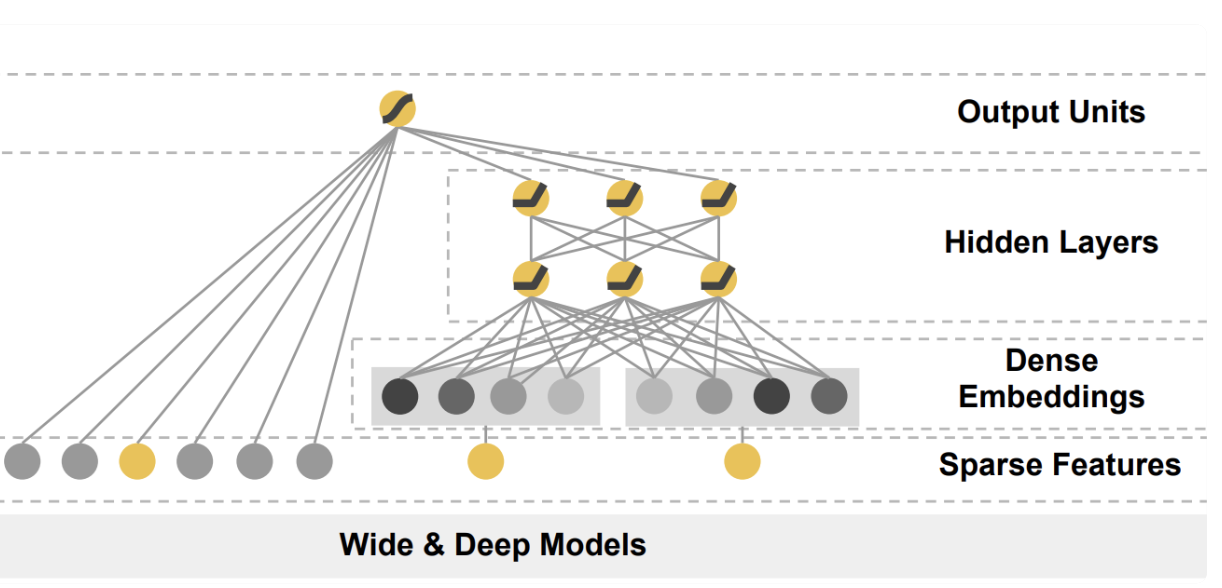

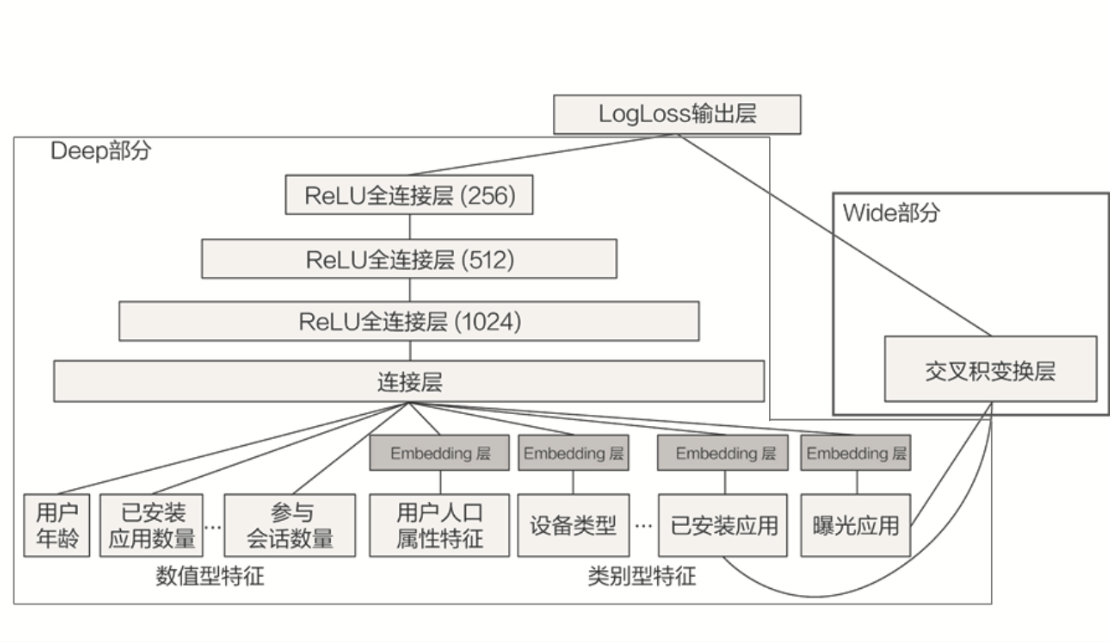